In [ ]:
import json
import datetime
import ast
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, XGBRegressor
from wordcloud import WordCloud, STOPWORDS
import plotly
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
sns.set(font_scale=1.25)
pd.set_option('display.max_colwidth', 50)

# Data Preprocessing

In [ ]:
df = pd.read_csv('movies_metadata.csv')

In [ ]:
def clean_numeric(x):
    try:
        return float(x)
    except:
        return np.nan

def get_month(x):
    try:
        return month_order[int(str(x).split('-')[1]) - 1]
    except:
        return np.nan

def convert_int(x):
    try:
        return int(x)
    except:
        return np.nan
df['id'] = df['id'].apply(convert_int)

In [ ]:
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [ ]:
df = df.drop(['imdb_id'], axis=1)
df.drop(['original_title'], axis=1,inplace=True)
df['revenue'] = df['revenue'].replace(0, np.nan)
df['budget'] = pd.to_numeric(df['budget'], errors='coerce')
df['budget'] = df['budget'].replace(0, np.nan)
df['return'] = df['revenue'] / df['budget']
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
df['year'] = df['release_date'].dt.year
df.drop(['adult'],axis=1,inplace=True)
df['title'] = df['title'].astype('str')
df['overview'] = df['overview'].astype('str')
title_corpus = ' '.join(df['title'])
overview_corpus = ' '.join(df['overview'])
df['popularity'] = df['popularity'].apply(clean_numeric).astype('float')
df['vote_count'] = df['vote_count'].apply(clean_numeric).astype('float')
df['vote_average'] = df['vote_average'].apply(clean_numeric).astype('float')
df['vote_average'] = df['vote_average'].replace(0, np.nan)
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
day_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
df['month'] = df['release_date'].apply(get_month)
df['day'] = df['release_date'].dt.weekday
df['spoken_languages'] = df['spoken_languages'].fillna('[]').apply(ast.literal_eval).apply(lambda x: len(x) if isinstance(x, list) else np.nan)
df['runtime'] = df['runtime'].astype(float)
df['genres'] = df['genres'].fillna('[]').apply(ast.literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

# Preprocess

In [ ]:
rgf = df[df['return'].notnull()]
rgf.shape

(5381, 25)

In [ ]:
s = rgf.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'genre'

In [ ]:
gen_rgf = rgf.drop('genres', axis=1).join(s)

In [ ]:
genres_train = gen_rgf['genre'].drop_duplicates()

In [ ]:
rgf.describe()

,budget,id,popularity,revenue,runtime,spoken_languages,vote_average,vote_count,return,year,day
count,5.381000e+03,5381.000000,5381.000000,5.381000e+03,5380.000000,5381.000000,5374.000000,5381.000000,5.381000e+03,5381.000000,5381.000000
mean,3.109480e+07,60664.565508,9.774289,9.031812e+07,109.827695,1.481881,6.281020,732.309422,5.565899e+03,1999.757666,3.174131
std,4.016263e+07,95613.916930,13.818399,1.661423e+08,22.041188,0.927831,0.900524,1251.520813,2.168566e+05,15.919325,1.323075
min,1.000000e+00,5.000000,0.000001,1.000000e+00,0.000000,0.000000,1.000000,0.000000,5.217391e-07,1915.000000,0.000000
25%,5.037000e+06,8818.000000,5.443097,7.011317e+06,95.000000,1.000000,5.700000,77.000000,7.870443e-01,1994.000000,2.000000
50%,1.700000e+07,14396.000000,8.388773,2.991874e+07,106.000000,1.000000,6.300000,276.000000,2.056683e+00,2004.000000,4.000000
75%,4.000000e+07,59981.000000,11.720358,9.996575e+07,120.000000,2.000000,6.900000,798.000000,4.244444e+00,2011.000000,4.000000
max,3.800000e+08,443319.000000,547.488298,2.787965e+09,338.000000,9.000000,9.100000,14075.000000,1.239638e+07,2017.000000,6.000000


In [ ]:
rgf.loc[rgf[rgf['belongs_to_collection'].isnull()].index,
        'belongs_to_collection'] = np.nan
rgf['belongs_to_collection'] = np.where(rgf['belongs_to_collection'].isnull(), 0, 1)
rgf['belongs_to_collection']

0        1
1        1
3        1
5        1
8        1
        ..
45250    1
45399    1
45409    1
45412    1
45422    1
Name: belongs_to_collection, Length: 5381, dtype: int64

In [ ]:
rgf['belongs_to_collection'].value_counts()

1    5381
Name: belongs_to_collection, dtype: int64

In [ ]:
for genre in genres_train:
  rgf['is_' + str(genre)] = rgf['genres'].apply(lambda x: 1 if genre in x else 0)

rgf['genres_count'] = rgf['genres'].apply(lambda x: len(x))
rgf['is_english'] = rgf['original_language'].apply(lambda x: 1 if x=='en' else 0)
rgf.columns

Index(['belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'original_language', 'overview', 'popularity', 'poster_path',
       'production_companies', 'production_countries', 'release_date',
       'revenue', 'runtime', 'spoken_languages', 'status', 'tagline', 'title',
       'video', 'vote_average', 'vote_count', 'return', 'year', 'month', 'day',
       'is_Friday', 'is_Holiday', 'is_Animation', 'is_Comedy', 'is_Family',
       'is_Adventure', 'is_Fantasy', 'is_Drama', 'is_Romance', 'is_Action',
       'is_Crime', 'is_Thriller', 'is_History', 'is_Science Fiction',
       'is_Mystery', 'is_Horror', 'is_War', 'is_Foreign', 'is_Documentary',
       'is_Western', 'is_Music', 'is_nan', 'is_TV Movie', 'genres_count',
       'is_english'],
      dtype='object')

need to process data further

In [ ]:
rgf['is_Friday'] = rgf['day'].apply(lambda x: 1 if x==5 else 0)
rgf['is_Holiday'] = rgf['month'].apply(lambda x: 1 if x in ['Apr', 'May', 'Dec'] else 0)
rgf['runtime'] = rgf['runtime'].fillna(df['runtime'].mean())
rgf['vote_average'] = rgf['vote_average'].fillna(rgf['vote_average'].mean())
rgf.columns

Index(['belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'original_language', 'overview', 'popularity', 'poster_path',
       'production_companies', 'production_countries', 'release_date',
       'revenue', 'runtime', 'spoken_languages', 'status', 'tagline', 'title',
       'video', 'vote_average', 'vote_count', 'return', 'year', 'month', 'day',
       'is_Friday', 'is_Holiday', 'is_Animation', 'is_Comedy', 'is_Family',
       'is_Adventure', 'is_Fantasy', 'is_Drama', 'is_Romance', 'is_Action',
       'is_Crime', 'is_Thriller', 'is_History', 'is_Science Fiction',
       'is_Mystery', 'is_Horror', 'is_War', 'is_Foreign', 'is_Documentary',
       'is_Western', 'is_Music', 'is_nan', 'is_TV Movie', 'genres_count',
       'is_english'],
      dtype='object')

In [ ]:
featureList = [
    'budget',
    'popularity',
    'runtime',
    'vote_average',
    'vote_count',
    'cast_size',
    'crew_size',
    'belongs_to_collection',
    'is_Animation', 'is_Comedy', 'is_Family',
       'is_Adventure', 'is_Fantasy', 'is_Drama', 'is_Romance', 'is_Action',
       'is_Crime', 'is_Thriller', 'is_History', 'is_Science Fiction',
       'is_Horror',  'is_Western',
       'is_Friday', 'is_Holiday', 'revenue'
]


Start Classification

In [ ]:
X, y = rgf.drop('revenue', axis=1), rgf['revenue']
train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.75, test_size=0.25)

In [ ]:
reg = GradientBoostingRegressor()

In [ ]:
cls = df[df['return'].notnull()]
cls.shape

(5381, 25)

In [ ]:
cls['success'] = cls['return'].apply(lambda x: 1 if x >=1.2 else 0)
cls['belongs_to_collection'] = rgf['belongs_to_collection']

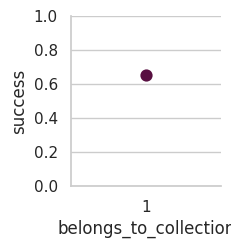

In [ ]:
sns.set(style="whitegrid")
g = sns.PairGrid(data=cls, x_vars=['belongs_to_collection'], y_vars='success')
g.map(sns.pointplot, color=sns.xkcd_rgb["plum"])
g.set(ylim=(0, 1))

In [ ]:
s = cls.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'genre'
gen_cls = cls.drop('genres', axis=1).join(s)

In [ ]:
ctab = pd.crosstab(
    [
        gen_cls['genre']
    ],
    gen_cls['success'],
    dropna=False
).apply(lambda x: x/x.sum(), axis=1)

In [ ]:
for genre in genres_train:
    cls['is_' + str(genre)] = cls['genres'].apply(lambda x: 1 if genre in x else 0)
cls['genres'] = cls['genres'].apply(lambda x: len(x))

In [ ]:
cls['is_english'] = rgf['is_english']
cls['is_Friday'] = rgf['is_Friday']
cls[['runtime', 'vote_average', 'is_Holiday']] = rgf[['runtime', 'vote_average', 'is_Holiday']]

In [ ]:
featureList = featureList = [
    'budget',
    'popularity',
    'runtime',
    'vote_average',
    'vote_count',
    'cast_size',
    'crew_size',
    'belongs_to_collection',
    'is_Animation', 'is_Comedy', 'is_Family',
       'is_Adventure', 'is_Fantasy', 'is_Drama', 'is_Romance', 'is_Action',
       'is_Crime', 'is_Thriller', 'is_History', 'is_Science Fiction',
       'is_Mystery', 'is_Horror', 'is_War', 'is_Foreign', 'is_Documentary',
       'is_Western', 'is_Music', 'is_nan', 'is_TV Movie', 'genres_count',
       'is_english', 'is_Friday', 'is_Holiday', 'success'
]

In [ ]:
X, y = cls[featureList].drop('success', axis=1), cls['success']

In [ ]:
train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.75, test_size=0.25, stratify=y)

In [ ]:
clf = GradientBoostingClassifier()
clf.fit(train_X, train_y)

Result

In [ ]:
plt.figure(figsize=(10,12))
sns.barplot(x=clf.feature_importances_, y=X.columns)

In [ ]:
featureImp = pd.DataFrame(
    {
        'col': X.columns,
        'imp': reg.feature_importances_
    }
)
featureImp.sort_values('imp', ascending=False)

In [ ]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 6.5 MB/s eta 0:00:00


In [ ]:
import shap

In [ ]:
explainer = shap.Explainer(clf2.predict, test_X)
shap_values= explainer(test_X)
shap.plots.bar(shap_values)

# Item Based

In [ ]:
!pip surprise

In [ ]:
from surprise.prediction_algorithms.knns import KNNBasic

In [ ]:
sim_options = {
    'name': 'cosine',
    'user_based': False
}
sim_item = KNNBasic(sim_options=sim_options,
                    verbose=False,
                    random_state=33)

sim_item.fit(trainset)

In [ ]:
sim_item.predict(uid=3, iid=17, r_ui=5.0)

In [ ]:
get_recommendations(ratings, movies_md, 671,10,sim_item)

In [ ]:
import json
import datetime
import ast
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, XGBRegressor
from wordcloud import WordCloud, STOPWORDS
import plotly
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
sns.set(font_scale=1.25)
pd.set_option('display.max_colwidth', 50)

# Data Preprocessing

In [ ]:
df = pd.read_csv('movies_metadata.csv')

In [ ]:
def clean_numeric(x):
    try:
        return float(x)
    except:
        return np.nan

def get_month(x):
    try:
        return month_order[int(str(x).split('-')[1]) - 1]
    except:
        return np.nan

def convert_int(x):
    try:
        return int(x)
    except:
        return np.nan
df['id'] = df['id'].apply(convert_int)

In [ ]:
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [ ]:
df = df.drop(['imdb_id'], axis=1)
df.drop(['original_title'], axis=1,inplace=True)
df['revenue'] = df['revenue'].replace(0, np.nan)
df['budget'] = pd.to_numeric(df['budget'], errors='coerce')
df['budget'] = df['budget'].replace(0, np.nan)
df['return'] = df['revenue'] / df['budget']
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
df['year'] = df['release_date'].dt.year
df.drop(['adult'],axis=1,inplace=True)
df['title'] = df['title'].astype('str')
df['overview'] = df['overview'].astype('str')
title_corpus = ' '.join(df['title'])
overview_corpus = ' '.join(df['overview'])
df['popularity'] = df['popularity'].apply(clean_numeric).astype('float')
df['vote_count'] = df['vote_count'].apply(clean_numeric).astype('float')
df['vote_average'] = df['vote_average'].apply(clean_numeric).astype('float')
df['vote_average'] = df['vote_average'].replace(0, np.nan)
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
day_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
df['month'] = df['release_date'].apply(get_month)
df['day'] = df['release_date'].dt.weekday
df['spoken_languages'] = df['spoken_languages'].fillna('[]').apply(ast.literal_eval).apply(lambda x: len(x) if isinstance(x, list) else np.nan)
df['runtime'] = df['runtime'].astype(float)
df['genres'] = df['genres'].fillna('[]').apply(ast.literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [ ]:
rgf = df[df['return'].notnull()]
rgf.shape

(5381, 25)

In [ ]:
s = rgf.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'genre'

In [ ]:
gen_rgf = rgf.drop('genres', axis=1).join(s)

In [ ]:
genres_train = gen_rgf['genre'].drop_duplicates()

In [ ]:
rgf.describe()

,budget,id,popularity,revenue,runtime,spoken_languages,vote_average,vote_count,return,year,day
count,5.381000e+03,5381.000000,5381.000000,5.381000e+03,5380.000000,5381.000000,5374.000000,5381.000000,5.381000e+03,5381.000000,5381.000000
mean,3.109480e+07,60664.565508,9.774289,9.031812e+07,109.827695,1.481881,6.281020,732.309422,5.565899e+03,1999.757666,3.174131
std,4.016263e+07,95613.916930,13.818399,1.661423e+08,22.041188,0.927831,0.900524,1251.520813,2.168566e+05,15.919325,1.323075
min,1.000000e+00,5.000000,0.000001,1.000000e+00,0.000000,0.000000,1.000000,0.000000,5.217391e-07,1915.000000,0.000000
25%,5.037000e+06,8818.000000,5.443097,7.011317e+06,95.000000,1.000000,5.700000,77.000000,7.870443e-01,1994.000000,2.000000
50%,1.700000e+07,14396.000000,8.388773,2.991874e+07,106.000000,1.000000,6.300000,276.000000,2.056683e+00,2004.000000,4.000000
75%,4.000000e+07,59981.000000,11.720358,9.996575e+07,120.000000,2.000000,6.900000,798.000000,4.244444e+00,2011.000000,4.000000
max,3.800000e+08,443319.000000,547.488298,2.787965e+09,338.000000,9.000000,9.100000,14075.000000,1.239638e+07,2017.000000,6.000000


In [ ]:
rgf.loc[rgf[rgf['belongs_to_collection'].isnull()].index,
        'belongs_to_collection'] = np.nan
rgf['belongs_to_collection'] = np.where(rgf['belongs_to_collection'].isnull(), 0, 1)
rgf['belongs_to_collection']

0        1
1        1
3        1
5        1
8        1
        ..
45250    1
45399    1
45409    1
45412    1
45422    1
Name: belongs_to_collection, Length: 5381, dtype: int64

In [ ]:
rgf['belongs_to_collection'].value_counts()

1    5381
Name: belongs_to_collection, dtype: int64

In [ ]:
for genre in genres_train:
  rgf['is_' + str(genre)] = rgf['genres'].apply(lambda x: 1 if genre in x else 0)

rgf['genres_count'] = rgf['genres'].apply(lambda x: len(x))
rgf['is_english'] = rgf['original_language'].apply(lambda x: 1 if x=='en' else 0)
rgf.columns

Index(['belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'original_language', 'overview', 'popularity', 'poster_path',
       'production_companies', 'production_countries', 'release_date',
       'revenue', 'runtime', 'spoken_languages', 'status', 'tagline', 'title',
       'video', 'vote_average', 'vote_count', 'return', 'year', 'month', 'day',
       'is_Friday', 'is_Holiday', 'is_Animation', 'is_Comedy', 'is_Family',
       'is_Adventure', 'is_Fantasy', 'is_Drama', 'is_Romance', 'is_Action',
       'is_Crime', 'is_Thriller', 'is_History', 'is_Science Fiction',
       'is_Mystery', 'is_Horror', 'is_War', 'is_Foreign', 'is_Documentary',
       'is_Western', 'is_Music', 'is_nan', 'is_TV Movie', 'genres_count',
       'is_english'],
      dtype='object')

need to process data further

In [ ]:
rgf['is_Friday'] = rgf['day'].apply(lambda x: 1 if x==5 else 0)
rgf['is_Holiday'] = rgf['month'].apply(lambda x: 1 if x in ['Apr', 'May', 'Dec'] else 0)
rgf['runtime'] = rgf['runtime'].fillna(df['runtime'].mean())
rgf['vote_average'] = rgf['vote_average'].fillna(rgf['vote_average'].mean())
rgf.columns

Index(['belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'original_language', 'overview', 'popularity', 'poster_path',
       'production_companies', 'production_countries', 'release_date',
       'revenue', 'runtime', 'spoken_languages', 'status', 'tagline', 'title',
       'video', 'vote_average', 'vote_count', 'return', 'year', 'month', 'day',
       'is_Friday', 'is_Holiday', 'is_Animation', 'is_Comedy', 'is_Family',
       'is_Adventure', 'is_Fantasy', 'is_Drama', 'is_Romance', 'is_Action',
       'is_Crime', 'is_Thriller', 'is_History', 'is_Science Fiction',
       'is_Mystery', 'is_Horror', 'is_War', 'is_Foreign', 'is_Documentary',
       'is_Western', 'is_Music', 'is_nan', 'is_TV Movie', 'genres_count',
       'is_english'],
      dtype='object')

In [ ]:
featureList = [
    'budget',
    'popularity',
    'runtime',
    'vote_average',
    'vote_count',
    'cast_size',
    'crew_size',
    'belongs_to_collection',
    'is_Animation', 'is_Comedy', 'is_Family',
       'is_Adventure', 'is_Fantasy', 'is_Drama', 'is_Romance', 'is_Action',
       'is_Crime', 'is_Thriller', 'is_History', 'is_Science Fiction',
       'is_Horror',  'is_Western',
       'is_Friday', 'is_Holiday', 'revenue'
]


Start Classification

In [ ]:
X, y = rgf.drop('revenue', axis=1), rgf['revenue']
train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.75, test_size=0.25)

In [ ]:
reg = GradientBoostingRegressor()

In [ ]:
cls = df[df['return'].notnull()]
cls.shape

(5381, 25)

In [ ]:
cls['success'] = cls['return'].apply(lambda x: 1 if x >=1.2 else 0)
cls['belongs_to_collection'] = rgf['belongs_to_collection']

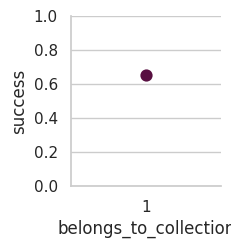

In [ ]:
sns.set(style="whitegrid")
g = sns.PairGrid(data=cls, x_vars=['belongs_to_collection'], y_vars='success')
g.map(sns.pointplot, color=sns.xkcd_rgb["plum"])
g.set(ylim=(0, 1))

In [ ]:
s = cls.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'genre'
gen_cls = cls.drop('genres', axis=1).join(s)

In [ ]:
ctab = pd.crosstab(
    [
        gen_cls['genre']
    ],
    gen_cls['success'],
    dropna=False
).apply(lambda x: x/x.sum(), axis=1)

In [ ]:
for genre in genres_train:
    cls['is_' + str(genre)] = cls['genres'].apply(lambda x: 1 if genre in x else 0)
cls['genres'] = cls['genres'].apply(lambda x: len(x))

In [ ]:
cls['is_english'] = rgf['is_english']
cls['is_Friday'] = rgf['is_Friday']
cls[['runtime', 'vote_average', 'is_Holiday']] = rgf[['runtime', 'vote_average', 'is_Holiday']]

In [ ]:
featureList = featureList = [
    'budget',
    'popularity',
    'runtime',
    'vote_average',
    'vote_count',
    'cast_size',
    'crew_size',
    'belongs_to_collection',
    'is_Animation', 'is_Comedy', 'is_Family',
       'is_Adventure', 'is_Fantasy', 'is_Drama', 'is_Romance', 'is_Action',
       'is_Crime', 'is_Thriller', 'is_History', 'is_Science Fiction',
       'is_Mystery', 'is_Horror', 'is_War', 'is_Foreign', 'is_Documentary',
       'is_Western', 'is_Music', 'is_nan', 'is_TV Movie', 'genres_count',
       'is_english', 'is_Friday', 'is_Holiday', 'success'
]

In [ ]:
X, y = cls[featureList].drop('success', axis=1), cls['success']

In [ ]:
train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.75, test_size=0.25, stratify=y)

In [ ]:
clf = GradientBoostingClassifier()
clf.fit(train_X, train_y)

Result

In [ ]:
plt.figure(figsize=(10,12))
sns.barplot(x=clf.feature_importances_, y=X.columns)

In [ ]:
featureImp = pd.DataFrame(
    {
        'col': X.columns,
        'imp': reg.feature_importances_
    }
)
featureImp.sort_values('imp', ascending=False)

In [ ]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 6.5 MB/s eta 0:00:00


In [ ]:
import shap

In [ ]:
explainer = shap.Explainer(clf2.predict, test_X)
shap_values= explainer(test_X)
shap.plots.bar(shap_values)

# User-Based

In [ ]:
!pip surprise

In [ ]:
from surprise.prediction_algorithms.knns import KNNBasic

In [ ]:
sim_options = {
    'name': 'cosine',
    'user_based': True
}

sim_user = KNNBasic(sim_options=sim_options,
                    verbose=False,
                    random_state=33)
sim_user.fit(trainset)

In [ ]:
sim_user.predict(uid=2, iid=17, r_ui=5.0)

In [ ]:
get_recommendations(ratings,
                    movies_md,
                    671,10,sim_user)

In [ ]:
import json
import datetime
import ast
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, XGBRegressor
from wordcloud import WordCloud, STOPWORDS
import plotly
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
sns.set(font_scale=1.25)
pd.set_option('display.max_colwidth', 50)

# Data Preprocessing

In [ ]:
df = pd.read_csv('movies_metadata.csv')

In [ ]:
def clean_numeric(x):
    try:
        return float(x)
    except:
        return np.nan

def get_month(x):
    try:
        return month_order[int(str(x).split('-')[1]) - 1]
    except:
        return np.nan

def convert_int(x):
    try:
        return int(x)
    except:
        return np.nan
df['id'] = df['id'].apply(convert_int)

In [ ]:
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [ ]:
df = df.drop(['imdb_id'], axis=1)
df.drop(['original_title'], axis=1,inplace=True)
df['revenue'] = df['revenue'].replace(0, np.nan)
df['budget'] = pd.to_numeric(df['budget'], errors='coerce')
df['budget'] = df['budget'].replace(0, np.nan)
df['return'] = df['revenue'] / df['budget']
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
df['year'] = df['release_date'].dt.year
df.drop(['adult'],axis=1,inplace=True)
df['title'] = df['title'].astype('str')
df['overview'] = df['overview'].astype('str')
title_corpus = ' '.join(df['title'])
overview_corpus = ' '.join(df['overview'])
df['popularity'] = df['popularity'].apply(clean_numeric).astype('float')
df['vote_count'] = df['vote_count'].apply(clean_numeric).astype('float')
df['vote_average'] = df['vote_average'].apply(clean_numeric).astype('float')
df['vote_average'] = df['vote_average'].replace(0, np.nan)
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
day_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
df['month'] = df['release_date'].apply(get_month)
df['day'] = df['release_date'].dt.weekday
df['spoken_languages'] = df['spoken_languages'].fillna('[]').apply(ast.literal_eval).apply(lambda x: len(x) if isinstance(x, list) else np.nan)
df['runtime'] = df['runtime'].astype(float)
df['genres'] = df['genres'].fillna('[]').apply(ast.literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [ ]:
rgf = df[df['return'].notnull()]
rgf.shape

(5381, 25)

In [ ]:
s = rgf.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'genre'

In [ ]:
gen_rgf = rgf.drop('genres', axis=1).join(s)

In [ ]:
genres_train = gen_rgf['genre'].drop_duplicates()

In [ ]:
rgf.describe()

,budget,id,popularity,revenue,runtime,spoken_languages,vote_average,vote_count,return,year,day
count,5.381000e+03,5381.000000,5381.000000,5.381000e+03,5380.000000,5381.000000,5374.000000,5381.000000,5.381000e+03,5381.000000,5381.000000
mean,3.109480e+07,60664.565508,9.774289,9.031812e+07,109.827695,1.481881,6.281020,732.309422,5.565899e+03,1999.757666,3.174131
std,4.016263e+07,95613.916930,13.818399,1.661423e+08,22.041188,0.927831,0.900524,1251.520813,2.168566e+05,15.919325,1.323075
min,1.000000e+00,5.000000,0.000001,1.000000e+00,0.000000,0.000000,1.000000,0.000000,5.217391e-07,1915.000000,0.000000
25%,5.037000e+06,8818.000000,5.443097,7.011317e+06,95.000000,1.000000,5.700000,77.000000,7.870443e-01,1994.000000,2.000000
50%,1.700000e+07,14396.000000,8.388773,2.991874e+07,106.000000,1.000000,6.300000,276.000000,2.056683e+00,2004.000000,4.000000
75%,4.000000e+07,59981.000000,11.720358,9.996575e+07,120.000000,2.000000,6.900000,798.000000,4.244444e+00,2011.000000,4.000000
max,3.800000e+08,443319.000000,547.488298,2.787965e+09,338.000000,9.000000,9.100000,14075.000000,1.239638e+07,2017.000000,6.000000


In [ ]:
rgf.loc[rgf[rgf['belongs_to_collection'].isnull()].index,
        'belongs_to_collection'] = np.nan
rgf['belongs_to_collection'] = np.where(rgf['belongs_to_collection'].isnull(), 0, 1)
rgf['belongs_to_collection']

0        1
1        1
3        1
5        1
8        1
        ..
45250    1
45399    1
45409    1
45412    1
45422    1
Name: belongs_to_collection, Length: 5381, dtype: int64

In [ ]:
rgf['belongs_to_collection'].value_counts()

1    5381
Name: belongs_to_collection, dtype: int64

In [ ]:
for genre in genres_train:
  rgf['is_' + str(genre)] = rgf['genres'].apply(lambda x: 1 if genre in x else 0)

rgf['genres_count'] = rgf['genres'].apply(lambda x: len(x))
rgf['is_english'] = rgf['original_language'].apply(lambda x: 1 if x=='en' else 0)
rgf.columns

Index(['belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'original_language', 'overview', 'popularity', 'poster_path',
       'production_companies', 'production_countries', 'release_date',
       'revenue', 'runtime', 'spoken_languages', 'status', 'tagline', 'title',
       'video', 'vote_average', 'vote_count', 'return', 'year', 'month', 'day',
       'is_Friday', 'is_Holiday', 'is_Animation', 'is_Comedy', 'is_Family',
       'is_Adventure', 'is_Fantasy', 'is_Drama', 'is_Romance', 'is_Action',
       'is_Crime', 'is_Thriller', 'is_History', 'is_Science Fiction',
       'is_Mystery', 'is_Horror', 'is_War', 'is_Foreign', 'is_Documentary',
       'is_Western', 'is_Music', 'is_nan', 'is_TV Movie', 'genres_count',
       'is_english'],
      dtype='object')

need to process data further

In [ ]:
rgf['is_Friday'] = rgf['day'].apply(lambda x: 1 if x==5 else 0)
rgf['is_Holiday'] = rgf['month'].apply(lambda x: 1 if x in ['Apr', 'May', 'Dec'] else 0)
rgf['runtime'] = rgf['runtime'].fillna(df['runtime'].mean())
rgf['vote_average'] = rgf['vote_average'].fillna(rgf['vote_average'].mean())
rgf.columns

Index(['belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'original_language', 'overview', 'popularity', 'poster_path',
       'production_companies', 'production_countries', 'release_date',
       'revenue', 'runtime', 'spoken_languages', 'status', 'tagline', 'title',
       'video', 'vote_average', 'vote_count', 'return', 'year', 'month', 'day',
       'is_Friday', 'is_Holiday', 'is_Animation', 'is_Comedy', 'is_Family',
       'is_Adventure', 'is_Fantasy', 'is_Drama', 'is_Romance', 'is_Action',
       'is_Crime', 'is_Thriller', 'is_History', 'is_Science Fiction',
       'is_Mystery', 'is_Horror', 'is_War', 'is_Foreign', 'is_Documentary',
       'is_Western', 'is_Music', 'is_nan', 'is_TV Movie', 'genres_count',
       'is_english'],
      dtype='object')

In [ ]:
featureList = [
    'budget',
    'popularity',
    'runtime',
    'vote_average',
    'vote_count',
    'cast_size',
    'crew_size',
    'belongs_to_collection',
    'is_Animation', 'is_Comedy', 'is_Family',
       'is_Adventure', 'is_Fantasy', 'is_Drama', 'is_Romance', 'is_Action',
       'is_Crime', 'is_Thriller', 'is_History', 'is_Science Fiction',
       'is_Horror',  'is_Western',
       'is_Friday', 'is_Holiday', 'revenue'
]


Start Classification

In [ ]:
X, y = rgf.drop('revenue', axis=1), rgf['revenue']
train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.75, test_size=0.25)

In [ ]:
reg = GradientBoostingRegressor()

In [ ]:
cls = df[df['return'].notnull()]
cls.shape

(5381, 25)

In [ ]:
cls['success'] = cls['return'].apply(lambda x: 1 if x >=1.2 else 0)
cls['belongs_to_collection'] = rgf['belongs_to_collection']

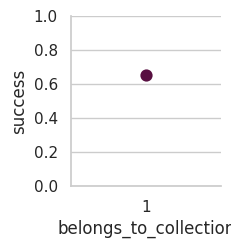

In [ ]:
sns.set(style="whitegrid")
g = sns.PairGrid(data=cls, x_vars=['belongs_to_collection'], y_vars='success')
g.map(sns.pointplot, color=sns.xkcd_rgb["plum"])
g.set(ylim=(0, 1))

In [ ]:
s = cls.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'genre'
gen_cls = cls.drop('genres', axis=1).join(s)

In [ ]:
ctab = pd.crosstab(
    [
        gen_cls['genre']
    ],
    gen_cls['success'],
    dropna=False
).apply(lambda x: x/x.sum(), axis=1)

In [ ]:
for genre in genres_train:
    cls['is_' + str(genre)] = cls['genres'].apply(lambda x: 1 if genre in x else 0)
cls['genres'] = cls['genres'].apply(lambda x: len(x))

In [ ]:
cls['is_english'] = rgf['is_english']
cls['is_Friday'] = rgf['is_Friday']
cls[['runtime', 'vote_average', 'is_Holiday']] = rgf[['runtime', 'vote_average', 'is_Holiday']]

In [ ]:
featureList = featureList = [
    'budget',
    'popularity',
    'runtime',
    'vote_average',
    'vote_count',
    'cast_size',
    'crew_size',
    'belongs_to_collection',
    'is_Animation', 'is_Comedy', 'is_Family',
       'is_Adventure', 'is_Fantasy', 'is_Drama', 'is_Romance', 'is_Action',
       'is_Crime', 'is_Thriller', 'is_History', 'is_Science Fiction',
       'is_Mystery', 'is_Horror', 'is_War', 'is_Foreign', 'is_Documentary',
       'is_Western', 'is_Music', 'is_nan', 'is_TV Movie', 'genres_count',
       'is_english', 'is_Friday', 'is_Holiday', 'success'
]

In [ ]:
X, y = cls[featureList].drop('success', axis=1), cls['success']

In [ ]:
train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.75, test_size=0.25, stratify=y)

In [ ]:
clf = GradientBoostingClassifier()
clf.fit(train_X, train_y)

Result

In [ ]:
plt.figure(figsize=(10,12))
sns.barplot(x=clf.feature_importances_, y=X.columns)

In [ ]:
featureImp = pd.DataFrame(
    {
        'col': X.columns,
        'imp': reg.feature_importances_
    }
)
featureImp.sort_values('imp', ascending=False)

In [ ]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 6.5 MB/s eta 0:00:00


In [ ]:
import shap

In [ ]:
explainer = shap.Explainer(clf2.predict, test_X)
shap_values= explainer(test_X)
shap.plots.bar(shap_values)

# Suggestion Based Recommender

In [ ]:
df = df[df['vote_count'] >= 50]

In [ ]:
movies_md = df[['id', 'original_title', 'overview', 'genres']]
movies_md['title'] = movies_md['original_title'].copy()
movies_md.reset_index(inplace=True, drop=True)
movies_md.head()

In [ ]:
movies_md = movies_md[movies_md['id'].str.isnumeric()]
movies_md['id'] = movies_md['id'].astype(int)
df = pd.merge(movies_md,
         keywords_df,
         on = 'id',
         how = 'left')
credits_df = pd.read_csv('./credits.csv')

In [ ]:
df = pd.merge(df,
              credits_df,
              on = 'id',
              how='left')
df.reset_index(inplace=True, drop=True)

In [ ]:
# Fetchin the genre list from the column
df['genres'] = df['genres'].apply(lambda x: [i['name'] for i in eval(x)])

# Replaces spaces in between genre(ex - sci fi to scifi) and make it a string
df['genres'] = df['genres'].apply(lambda x: ' '.join([i.replace(" ","") for i in x]))


In [ ]:
# Filling the numm values as []
df['keywords'].fillna('[]', inplace=True)
# Let's clean the keywords dataframe to extract the keywords
# Fetchin the keyword list from the column
df['keywords'] = df['keywords'].apply(lambda x: [i['name'] for i in eval(x)])

# Remove the expty spaces and join all the keyword wwwith spaces
df['keywords'] = df['keywords'].apply(lambda x: ' '.join([i.replace(" ",'') for i in x]))

In [ ]:
# Filling the numm values as []
df['cast'].fillna('[]', inplace=True)
# Let's clean the cast dataframe to extract the name of aactors from cast column
# Fetchin the cast list from the column
df['cast'] = df['cast'].apply(lambda x: [i['name'] for i in eval(x)])

# Remove the expty spaces and join all the cast with spaces
df['cast'] = df['cast'].apply(lambda x: ' '.join([i.replace(" ",'') for i in x]))

In [ ]:
df['tags'] = df['overview'] + ' ' + df['genres'] + ' ' + df['original_title'] + ' ' + df['keywords'] + ' ' + df['cast']
df.drop(columns=['genres','overview', 'original_title', 'cast'], inplace=True)
df.drop(columns=['crew'], inplace=True)
df.drop(df[df['tags'].isnull()].index, inplace=True)
df.drop_duplicates(inplace=True)

Convert the contents to vectors

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Initialize a tfidf object
tfidf = TfidfVectorizer(max_features=5000)

# Transform the data
vectorized_data = tfidf.fit_transform(df['tags'].values)

vectorized_data

Dimension Reduction

In [ ]:
from sklearn.decomposition import TruncatedSVD

# Initialize a PCA object
svd = TruncatedSVD(n_components=3000)

# Fit transform the data
reduced_data = svd.fit_transform(vectorized_data)

# Print the shape
reduced_data.shape
svd.explained_variance_ratio_.cumsum()

Similarity Metric

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
similarity = cosine_similarity(reduced_data)

Make Recommendations for a given movie

In [ ]:
def recommendations(movie_title):
  id_of_movie = df[df['title'] == movie_title].index[0]
  distances = similarity[id_of_movie]
  movie_list = sorted(
      list(
          enumerate(distances)
      ),
      reverse=True,
      key = lambda x: x[1]
  )[1:10]

  for i in movie_list:
    print(df.iloc[i[0]].title)

In [ ]:
recommendations('The Matrix')

Visualize using TSNE

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
# Initialize TSNE object
tsne = TSNE(n_components=2, init='random')

tsne_data = tsne.fit_transform(vectorized_data)

tsne_data = pd.DataFrame(tsne_data,
                         columns=['x', 'y'])

tsne_data['title'] = df['title'].copy()

In [ ]:
data = go.Scatter(
    x=tsne_data['x'],
    y=tsne_data['y'],
    text=tsne_data['title'],
    mode='markers+text'
)

fig = go.Figure(data=data)
fig.show()

In [ ]:
import json
import datetime
import ast
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, XGBRegressor
from wordcloud import WordCloud, STOPWORDS
import plotly
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
sns.set(font_scale=1.25)
pd.set_option('display.max_colwidth', 50)

In [ ]:
df = pd.read_csv('movies_metadata.csv')

# Data Processing

Like what Yina did in class, create a function 'clean_numeric' to convert its input to a float, returning NaN on failure. get_month extracts the month from a date string, returning the corresponding month name or NaN if the extraction fails. convert_int tries to convert its input to an integer, again defaulting to NaN if it cannot. These functions are part of the data cleaning process, ensuring that the DataFrame's columns are in the correct format for analysis. The convert_int function is specifically applied to the 'id' column of the DataFrame, converting its values into integers or NaN.

In [ ]:
def clean_numeric(x):
    try:
        return float(x)
    except:
        return np.nan

def get_month(x):
    try:
        return month_order[int(str(x).split('-')[1]) - 1]
    except:
        return np.nan

def convert_int(x):
    try:
        return int(x)
    except:
        return np.nan
df['id'] = df['id'].apply(convert_int)

Secondly, columns like 'imdb_id', 'original_title', and 'adult' are removed from the DataFrame to streamline the dataset.I want to write a code to remove the column 'imdb_id' from the DataFrame. then it removes the column 'original_title' from the DataFrame. Replaces all zero values in the 'revenue' column with NaN (Not a Number), which is a standard missing value marker in pandas.

In [ ]:
df = df.drop(['imdb_id'], axis=1)
df['revenue'] = df['revenue'].replace(0, np.nan)

Numeric transformations are applied to the 'revenue' and 'budget' columns, where zeros are replaced with NaN (indicating missing values), and the 'budget' column is explicitly converted to numeric type. A new column 'return' is calculated by dividing 'revenue' by 'budget'.

In [ ]:
df['budget'] = pd.to_numeric(df['budget'], errors='coerce')
df['budget'] = df['budget'].replace(0, np.nan)
df['return'] = df['revenue'] / df['budget']

The 'release_date' is converted to a DateTime format, and from this, a new 'year' column is extracted. The 'title' and 'overview' columns are converted to string type, and then all titles and overviews are concatenated into two large strings, respectively.

In [ ]:
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
df['year'] = df['release_date'].dt.year
df.drop(['adult'],axis=1,inplace=True)
df['title'] = df['title'].astype('str')
df['overview'] = df['overview'].astype('str')
title_corpus = ' '.join(df['title'])
overview_corpus = ' '.join(df['overview'])

The 'popularity', 'vote_count', and 'vote_average' columns are processed through a custom function clean_numeric to ensure they are numeric, with zeros in 'vote_average' replaced with NaN. The release date is further utilized to create new columns 'month' and 'day', representing the month and weekday of the release.

In [ ]:
df['popularity'] = df['popularity'].apply(clean_numeric).astype('float')
df['vote_count'] = df['vote_count'].apply(clean_numeric).astype('float')
df['vote_average'] = df['vote_average'].apply(clean_numeric).astype('float')
df['vote_average'] = df['vote_average'].replace(0, np.nan)
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
day_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
df['month'] = df['release_date'].apply(get_month)
df['day'] = df['release_date'].dt.weekday

The 'spoken_languages' and 'genres' columns are processed to transform them into more analyzable formats, and 'runtime' is converted to a float.

In [ ]:
df['spoken_languages'] = df['spoken_languages'].fillna('[]').apply(ast.literal_eval).apply(lambda x: len(x) if isinstance(x, list) else np.nan)
df['runtime'] = df['runtime'].astype(float)
df['genres'] = df['genres'].fillna('[]').apply(ast.literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [ ]:
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

Do the same thing to the Credit File

In [ ]:
credits_df = pd.read_csv('./credits.csv')

In [ ]:
keywords_df = pd.read_csv('./keywords.csv')

In [ ]:
keywords_df.iloc[0]['keywords']

"[{'id': 931, 'name': 'jealousy'}, {'id': 4290, 'name': 'toy'}, {'id': 5202, 'name': 'boy'}, {'id': 6054, 'name': 'friendship'}, {'id': 9713, 'name': 'friends'}, {'id': 9823, 'name': 'rivalry'}, {'id': 165503, 'name': 'boy next door'}, {'id': 170722, 'name': 'new toy'}, {'id': 187065, 'name': 'toy comes to life'}]"

## Regression

In [ ]:
rgf = df[df['return'].notnull()]
rgf.shape

(5393, 30)

In [ ]:
rgf['genres']

0             [Animation, Comedy, Family]
1            [Adventure, Fantasy, Family]
3                [Comedy, Drama, Romance]
5        [Action, Crime, Drama, Thriller]
8           [Action, Adventure, Thriller]
                       ...               
45323             [Action, Comedy, Drama]
45471                     [Crime, Comedy]
45481                     [Comedy, Drama]
45484                    [Romance, Drama]
45494    [Action, Comedy, Crime, Foreign]
Name: genres, Length: 5393, dtype: object

In [ ]:
s = rgf.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
#s.name = 'genre'
#s

In [ ]:
s.name = 'genre'
s

0        Animation
0           Comedy
0           Family
1        Adventure
1          Fantasy
           ...    
45484        Drama
45494       Action
45494       Comedy
45494        Crime
45494      Foreign
Name: genre, Length: 14048, dtype: object

In [ ]:
gen_rgf = rgf.drop('genres', axis=1).join(s)

In [ ]:
genres_train = gen_rgf['genre'].drop_duplicates()

In [ ]:
rgf.describe()

,budget,id,popularity,revenue,runtime,spoken_languages,vote_average,vote_count,return,year,day,cast_size,crew_size
count,5.393000e+03,5393.000000,5393.000000,5.393000e+03,5392.000000,5393.000000,5386.000000,5393.00000,5.393000e+03,5393.000000,5393.000000,5393.000000,5393.000000
mean,3.106844e+07,60619.040423,9.764355,9.017122e+07,109.811016,1.481179,6.280616,730.91730,5.553519e+03,1999.743371,3.061005,23.747636,29.281476
std,4.012743e+07,95530.467674,13.805589,1.659906e+08,22.030149,0.927084,0.900089,1250.48188,2.166154e+05,15.958675,1.618635,20.605691,33.017571
min,1.000000e+00,5.000000,0.000001,1.000000e+00,0.000000,0.000000,1.000000,0.00000,5.217391e-07,1915.000000,0.000000,0.000000,0.000000
25%,5.000000e+06,8831.000000,5.430566,7.000000e+06,95.000000,1.000000,5.700000,77.00000,7.865264e-01,1994.000000,2.000000,12.000000,9.000000
50%,1.700000e+07,14405.000000,8.378149,2.991874e+07,106.000000,1.000000,6.300000,276.00000,2.055172e+00,2004.000000,3.000000,17.000000,17.000000
75%,4.000000e+07,60062.000000,11.698089,9.931899e+07,120.000000,2.000000,6.900000,795.00000,4.245925e+00,2011.000000,4.000000,27.000000,35.000000
max,3.800000e+08,443319.000000,547.488298,2.787965e+09,338.000000,9.000000,9.100000,14075.00000,1.239638e+07,2017.000000,6.000000,313.000000,435.000000


In [ ]:
rgf.loc[rgf[rgf['belongs_to_collection'].isnull()].index,
        'belongs_to_collection'] = np.nan

In [ ]:
rgf['belongs_to_collection'] = np.where(rgf['belongs_to_collection'].isnull(), 0, 1)
rgf['belongs_to_collection']

0        1
1        0
3        0
5        0
8        0
        ..
45323    0
45471    0
45481    0
45484    0
45494    0
Name: belongs_to_collection, Length: 5393, dtype: int64

In [ ]:
rgf['belongs_to_collection'].value_counts()

0    4167
1    1226
Name: belongs_to_collection, dtype: int64

In [ ]:
for genre in genres_train:
  rgf['is_' + str(genre)] = rgf['genres'].apply(lambda x: 1 if genre in x else 0)
rgf.head()

,belongs_to_collection,budget,genres,homepage,id,original_language,overview,popularity,poster_path,production_companies,...,is_Science Fiction,is_Mystery,is_Horror,is_War,is_Foreign,is_Documentary,is_Western,is_Music,is_nan,is_TV Movie
0,1,30000000.0,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862.0,en,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]",...,0,0,0,0,0,0,0,0,0,0
1,0,65000000.0,"[Adventure, Fantasy, Family]",NaN,8844.0,en,When siblings Judy and Peter discover an encha...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...",...,0,0,0,0,0,0,0,0,0,0
3,0,16000000.0,"[Comedy, Drama, Romance]",NaN,31357.0,en,"Cheated on, mistreated and stepped on, the wom...",3.859495,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,...,0,0,0,0,0,0,0,0,0,0
5,0,60000000.0,"[Action, Crime, Drama, Thriller]",NaN,949.0,en,"Obsessive master thief, Neil McCauley leads a ...",17.924927,/zMyfPUelumio3tiDKPffaUpsQTD.jpg,"[{'name': 'Regency Enterprises', 'id': 508}, {...",...,0,0,0,0,0,0,0,0,0,0
8,0,35000000.0,"[Action, Adventure, Thriller]",NaN,9091.0,en,International action superstar Jean Claude Van...,5.231580,/eoWvKD60lT95Ss1MYNgVExpo5iU.jpg,"[{'name': 'Universal Pictures', 'id': 33}, {'n...",...,0,0,0,0,0,0,0,0,0,0


In [ ]:
rgf['genres_count'] = rgf['genres'].apply(lambda x: len(x))

In [ ]:
rgf['is_english'] = rgf['original_language'].apply(lambda x: 1 if x=='en' else 0)

In [ ]:
rgf['is_english'].value_counts()

1    4807
0     586
Name: is_english, dtype: int64

In [ ]:
rgf['day'].value_counts()

4.0    1686
3.0     946
2.0     946
1.0     533
0.0     460
5.0     431
6.0     391
Name: day, dtype: int64

In [ ]:
rgf['is_Friday'] = rgf['day'].apply(lambda x: 1 if x==5 else 0)

In [ ]:
rgf['month'].value_counts()

Dec    580
Sep    506
Jan    487
Oct    472
Jun    458
Aug    456
Nov    452
Jul    450
May    442
Mar    387
Apr    371
Feb    332
Name: month, dtype: int64

In [ ]:
rgf['is_Holiday'] = rgf['month'].apply(lambda x: 1 if x in ['Apr', 'May', 'Dec'] else 0)

In [ ]:
rgf['runtime'] = rgf['runtime'].fillna(df['runtime'].mean())

In [ ]:
rgf['vote_average'] = rgf['vote_average'].fillna(rgf['vote_average'].mean())

In [ ]:
rgf.columns

Index(['belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'original_language', 'overview', 'popularity', 'poster_path',
       'production_companies', 'production_countries', 'release_date',
       'revenue', 'runtime', 'spoken_languages', 'status', 'tagline', 'title',
       'video', 'vote_average', 'vote_count', 'return', 'year', 'month', 'day',
       'cast', 'crew', 'cast_size', 'crew_size', 'director', 'genres_count',
       'is_english', 'is_Animation', 'is_Comedy', 'is_Family', 'is_Adventure',
       'is_Fantasy', 'is_Drama', 'is_Romance', 'is_Action', 'is_Crime',
       'is_Thriller', 'is_History', 'is_Science Fiction', 'is_Mystery',
       'is_Horror', 'is_War', 'is_Foreign', 'is_Documentary', 'is_Western',
       'is_Music', 'is_nan', 'is_TV Movie', 'is_Friday', 'is_Holiday'],
      dtype='object')

In [ ]:
featureList = [
    'budget',
    'popularity',
    'runtime',
    'vote_average',
    'vote_count',
    'cast_size',
    'crew_size',
    'belongs_to_collection',
    'is_Animation', 'is_Comedy', 'is_Family',
       'is_Adventure', 'is_Fantasy', 'is_Drama', 'is_Romance', 'is_Action',
       'is_Crime', 'is_Thriller', 'is_History', 'is_Science Fiction',
       'is_Mystery', 'is_Horror', 'is_War', 'is_Foreign', 'is_Documentary',
       'is_Western', 'is_Music', 'is_nan', 'is_TV Movie', 'genres_count',
       'is_english', 'is_Friday', 'is_Holiday', 'revenue'
]

In [ ]:
rgf = pd.get_dummies(rgf[featureList], prefix='is')

In [ ]:
X, y = rgf.drop('revenue', axis=1), rgf['revenue']

In [ ]:
train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.75, test_size=0.25)

In [ ]:
train_X.shape

(4044, 33)

In [ ]:
reg = GradientBoostingRegressor()
reg.fit(train_X, train_y)


NameError: name 'testX' is not defined

In [ ]:
reg.score(test_X, test_y)

0.7589090080590963

In [ ]:
dummy = DummyRegressor()
dummy.fit(train_X, train_y)
dummy.score(test_X, test_y)

-5.4621887222605636e-05

In [ ]:
featureImp = pd.DataFrame(
    {
        'col': X.columns,
        'imp': reg.feature_importances_
    }
)

In [ ]:
featureImp.sort_values('imp', ascending=False)

,col,imp
4,vote_count,0.592303
0,budget,0.297346
1,popularity,0.026315
7,belongs_to_collection,0.021843
10,is_Family,0.015423
2,runtime,0.010483
3,vote_average,0.006123
12,is_Fantasy,0.004511
14,is_Romance,0.004094
6,crew_size,0.003957


In [ ]:
featureList = [
    'budget',
    'popularity',
    'runtime',
    'vote_average',
    'vote_count',
    'cast_size',
    'crew_size',
    'belongs_to_collection',
    'is_Animation', 'is_Comedy', 'is_Family',
       'is_Adventure', 'is_Fantasy', 'is_Drama', 'is_Romance', 'is_Action',
       'is_Crime', 'is_Thriller', 'is_History', 'is_Science Fiction',
       'is_Horror',  'is_Western',
       'is_Friday', 'is_Holiday', 'revenue'
]

In [ ]:
rgf_short = pd.get_dummies(rgf[featureList], prefix='is')

<Axes: ylabel='None'>

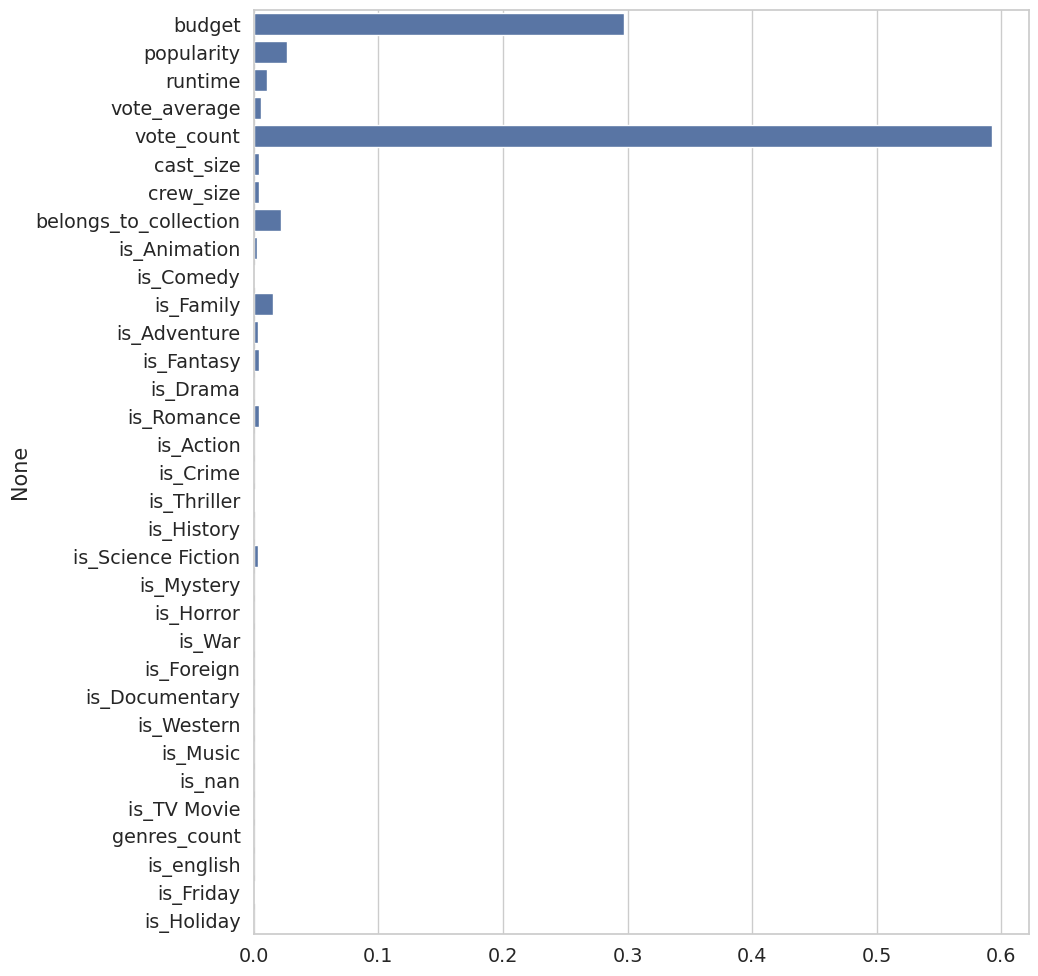

In [ ]:
sns.set_style('whitegrid')
plt.figure(figsize=(10,12))

sns.barplot(x= reg.feature_importances_,
            y =X.columns)

In [ ]:
X, y = rgf.drop('revenue', axis=1), rgf['revenue']
train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.75, test_size=0.25)

In [ ]:
reg2 = GradientBoostingRegressor()
reg2.fit(train_X, train_y)


GradientBoostingRegressor()

In [ ]:
reg2.score(test_X, test_y)

0.7872573084920682

## Classification: Predicting Movie Success

In [ ]:
cls = df[df['return'].notnull()]
cls.shape

(5393, 32)

In [ ]:
cls = cls.drop(['id', 'overview', 'poster_path', 'release_date', 'status', 'tagline', 'revenue'], axis=1)

In [ ]:
cls['success'] = cls['return'].apply(lambda x: 1 if x >=1.2 else 0)
cls['success'].value_counts()

1    3519
0    1874
Name: success, dtype: int64

In [ ]:
cls['belongs_to_collection'] = rgf['belongs_to_collection']

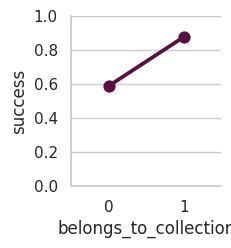

In [ ]:
sns.set(style="whitegrid")
g = sns.PairGrid(data=cls, x_vars=['belongs_to_collection'], y_vars='success')
g.map(sns.pointplot, color=sns.xkcd_rgb["plum"])
g.set(ylim=(0, 1))

In [ ]:
s = cls.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'genre'
gen_cls = cls.drop('genres', axis=1).join(s)

In [ ]:
ctab = pd.crosstab(
    [
        gen_cls['genre']
    ],
    gen_cls['success'],
    dropna=False
).apply(lambda x: x/x.sum(), axis=1)

In [ ]:
cls.columns

Index(['belongs_to_collection', 'budget', 'genres', 'homepage',
       'original_language', 'popularity', 'production_companies',
       'production_countries', 'runtime', 'spoken_languages', 'title', 'video',
       'vote_average', 'vote_count', 'return', 'year', 'month', 'day', 'cast',
       'crew', 'cast_size', 'crew_size', 'director', 'genres_count',
       'is_english', 'success'],
      dtype='object')

In [ ]:
for genre in genres_train:
    cls['is_' + str(genre)] = cls['genres'].apply(lambda x: 1 if genre in x else 0)
cls['genres'] = cls['genres'].apply(lambda x: len(x))

In [ ]:
cls['is_english'] = rgf['is_english']

In [ ]:
cls['is_Friday'] = rgf['is_Friday']
cls[['runtime', 'vote_average', 'is_Holiday']] = rgf[['runtime', 'vote_average', 'is_Holiday']]

In [ ]:
featureList = featureList = [
    'budget',
    'popularity',
    'runtime',
    'vote_average',
    'vote_count',
    'cast_size',
    'crew_size',
    'belongs_to_collection',
    'is_Animation', 'is_Comedy', 'is_Family',
       'is_Adventure', 'is_Fantasy', 'is_Drama', 'is_Romance', 'is_Action',
       'is_Crime', 'is_Thriller', 'is_History', 'is_Science Fiction',
       'is_Mystery', 'is_Horror', 'is_War', 'is_Foreign', 'is_Documentary',
       'is_Western', 'is_Music', 'is_nan', 'is_TV Movie', 'genres_count',
       'is_english', 'is_Friday', 'is_Holiday', 'success'
]

In [ ]:
X, y = cls[featureList].drop('success', axis=1), cls['success']

In [ ]:
train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.75, test_size=0.25, stratify=y)

In [ ]:
clf = GradientBoostingClassifier()
clf.fit(train_X, train_y)
clf.score(test_X, test_y)

0.765011119347665

<Axes: ylabel='None'>

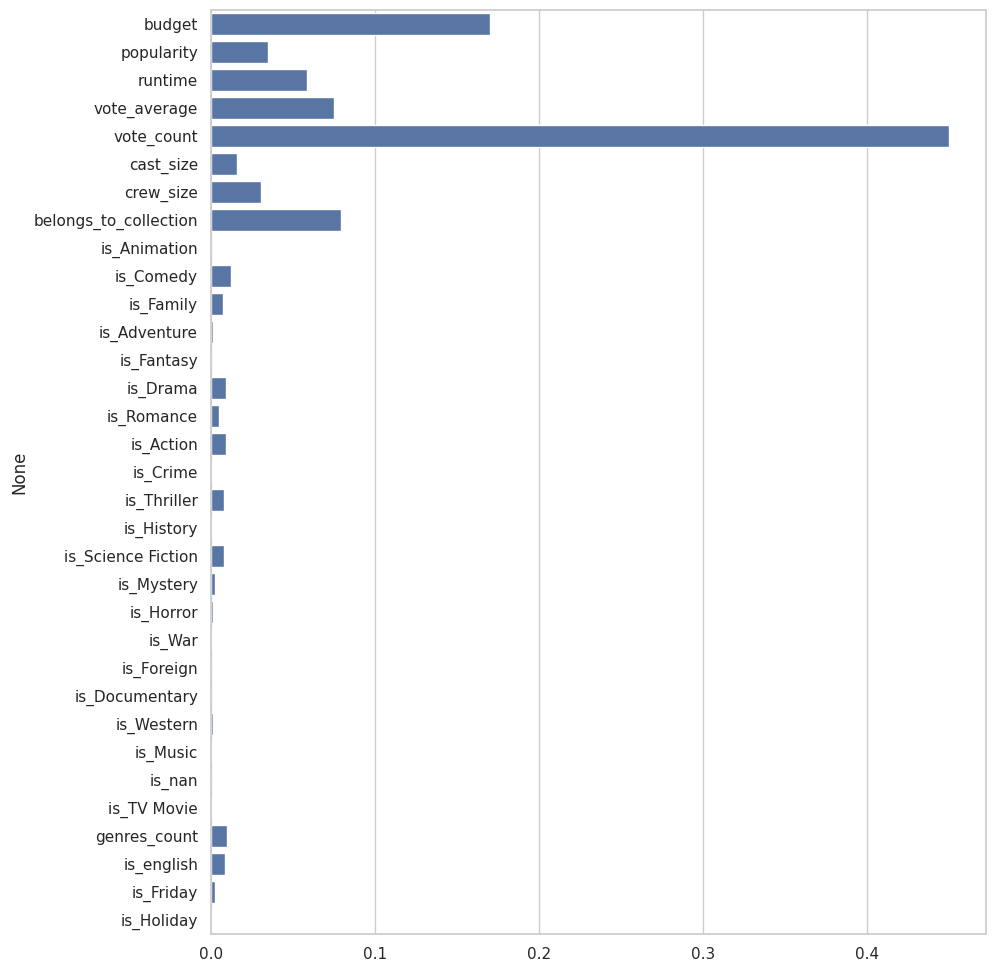

In [ ]:
plt.figure(figsize=(10,12))
sns.barplot(x=clf.feature_importances_, y=X.columns)

In [ ]:
featureImp = pd.DataFrame(
    {
        'col': X.columns,
        'imp': reg.feature_importances_
    }
)
featureImp.sort_values('imp', ascending=False)

,col,imp
4,vote_count,0.592303
0,budget,0.297346
1,popularity,0.026315
7,belongs_to_collection,0.021843
10,is_Family,0.015423
2,runtime,0.010483
3,vote_average,0.006123
12,is_Fantasy,0.004511
14,is_Romance,0.004094
6,crew_size,0.003957


In [ ]:
featureList = [
    'budget',
    'popularity',
    'runtime',
    'vote_average',
    'vote_count',
    'cast_size',
    'crew_size',
    'belongs_to_collection',
    'is_Animation', 'is_Comedy', 'is_Family',
       'is_Adventure', 'is_Fantasy', 'is_Drama', 'is_Romance', 'is_Action',
       'is_Crime', 'is_Thriller', 'is_History', 'is_Science Fiction',
       'is_Mystery', 'is_Horror', 'is_War', 'is_Foreign', 'is_Documentary',
       'is_Friday', 'is_Holiday', 'success'
]

In [ ]:
X, y = cls[featureList].drop('success', axis=1), cls['success']
train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.75, test_size=0.25, stratify=y)

In [ ]:
clf2 = GradientBoostingClassifier()
clf2.fit(train_X, train_y)
clf2.score(test_X, test_y)

0.7790956263899185

In [ ]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 5.7 MB/s eta 0:00:00


In [ ]:
import shap

In [ ]:
explainer = shap.Explainer(clf2.predict, test_X)
shap_values= explainer(test_X)

PermutationExplainer explainer: 1350it [01:46, 11.93it/s]


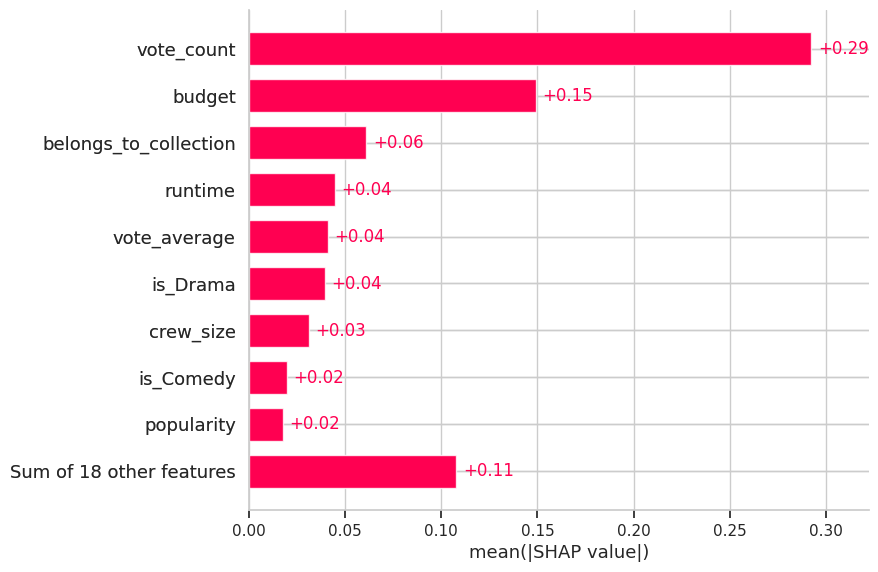

In [ ]:
shap.plots.bar(shap_values)

# Content Filtering

In [ ]:
df = df[df['vote_count'] >= 50]

In [ ]:
movies_md = df[['id', 'original_title', 'overview', 'genres']]
movies_md['title'] = movies_md['original_title'].copy()
movies_md.reset_index(inplace=True, drop=True)

In [ ]:
movies_md = movies_md[movies_md['id'].str.isnumeric()]

AttributeError: Can only use .str accessor with string values!

In [ ]:
movies_md['id'] = movies_md['id'].astype(int)

In [ ]:
df = pd.merge(movies_md,
         keywords_df,
         on = 'id',
         how = 'left')

In [ ]:
credits_df = pd.read_csv('./credits.csv')

In [ ]:
df = pd.merge(df,
              credits_df,
              on = 'id',
              how='left')
df.reset_index(inplace=True, drop=True)

So far we have a initialized dataset on which we can process more cleaning and engineering.

In [ ]:
df['genres'] = df['genres'].apply(lambda x: ' '.join([i.replace(" ","") for i in x]))
df['cast'].fillna('[]', inplace=True)
df['cast'] = df['cast'].apply(lambda x: [i['name'] for i in eval(x)])
df['cast'] = df['cast'].apply(lambda x: ' '.join([i.replace(" ",'') for i in x]))
df['keywords'].fillna('[]', inplace=True)
df['keywords'] = df['keywords'].apply(lambda x: [i['name'] for i in eval(x)])
df['keywords'] = df['keywords'].apply(lambda x: ' '.join([i.replace(" ",'') for i in x]))

In [ ]:
df['tags'] = df['overview'] + ' ' + df['genres'] + ' ' + df['original_title'] + ' ' + df['keywords'] + ' ' + df['cast']

In [ ]:
df.drop(columns=['genres','overview', 'original_title', 'cast'], inplace=True)

In [ ]:
df.drop(columns=['crew'], inplace=True)

In [ ]:
df.isnull().sum()

id           0
title        0
keywords     0
tags        38
dtype: int64

In [ ]:
df.drop(df[df['tags'].isnull()].index, inplace=True)


In [ ]:
df.shape

(9259, 4)

In [ ]:
df.drop_duplicates(inplace=True)

In [ ]:
df.shape

(9106, 4)

### Convert the contents to vectors

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
# Initialize a tfidf object
tfidf = TfidfVectorizer(max_features=5000)

# Transform the data
vectorized_data = tfidf.fit_transform(df['tags'].values)

In [ ]:
vectorized_data

<9106x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 396743 stored elements in Compressed Sparse Row format>

#### Dimension Reduction

In [ ]:
from sklearn.decomposition import TruncatedSVD

In [ ]:
# Initialize a PCA object
svd = TruncatedSVD(n_components=3000)

# Fit transform the data
reduced_data = svd.fit_transform(vectorized_data)

# Print the shape
reduced_data.shape

(9106, 3000)

In [ ]:
svd.explained_variance_ratio_.cumsum()

array([0.00478848, 0.01173921, 0.01743385, ..., 0.91805244, 0.91812678,
       0.91820077])

### Similarity Metric

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
similarity = cosine_similarity(reduced_data)

### Make Recommendations for a given movie

In [ ]:
def recommendations(movie_title):
  id_of_movie = df[df['title'] == movie_title].index[0]
  distances = similarity[id_of_movie]
  movie_list = sorted(
      list(
          enumerate(distances)
      ),
      reverse=True,
      key = lambda x: x[1]
  )[1:10]

  for i in movie_list:
    print(df.iloc[i[0]].title)

In [ ]:
recommendations('The Matrix')

The Matrix Revisited
The Matrix Revolutions
The Matrix Reloaded
The Animatrix
Commando
Hackers
Terminator 3: Rise of the Machines
GHOST IN THE SHELL
Tron


In [ ]:
recommendations('Jumanji')

Brainscan
Wreck-It Ralph
Stay Alive
Alan Partridge: Alpha Papa
Dungeons & Dragons
Nirvana
Geri's Game
Indie Game: The Movie
Beyond the Gates


#### Visualize using TSNE

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
# Initialize TSNE object
tsne = TSNE(n_components=2, init='random')

tsne_data = tsne.fit_transform(vectorized_data)

tsne_data = pd.DataFrame(tsne_data,
                         columns=['x', 'y'])

tsne_data['title'] = df['title'].copy()

In [ ]:
data = go.Scatter(
    x=tsne_data['x'],
    y=tsne_data['y'],
    text=tsne_data['title'],
    mode='markers+text'
)

fig = go.Figure(data=data)
fig.show()

## Collabrative Filtering

### Model Based Recommender Systems

Model-based recommendation systems involve building a model based on the dataset of ratings. In other words, we extract some information from the dataset, and use that as a "model" to make recommendations without having to use the complete dataset every time.

For model based recommender systems we are going to use a library called Surprise and we are going to use SVD as a matrix factorization method.

#### Singular Value Decomposition (SVD)

Singular Value Decomposition (SVD) is one of the matrix factorization method in machine learning. Singular value decomposition decomposes a matrix into three other matrices and extracts the features from the factorization of a high-level (user-item-rating) matrix.

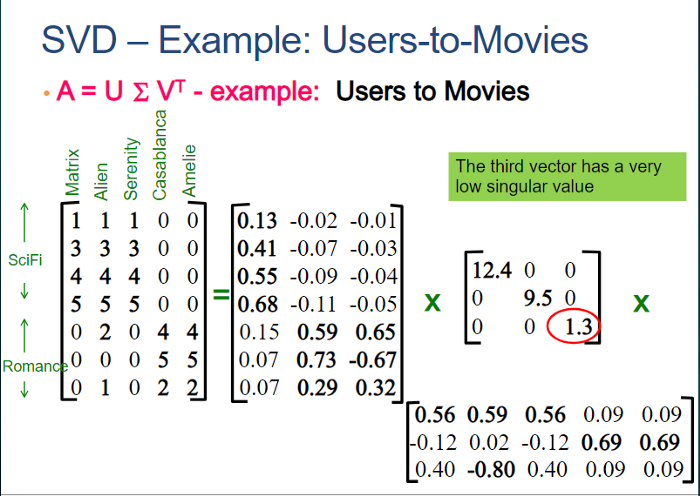

The formula of SVD can be given as -

image.png

Where,

Matrix U: Latent features of Users

Matrix S: Diagonal matrix representing the strength of each feature

Matrix U: Latent features of Items

In [ ]:
!pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3162674 sha256=01afd7648b4fb72db5d37c05af295b2033b7263b87c262f05f3228974db79962
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [ ]:
from surprise import Dataset, Reader

from surprise.prediction_algorithms.matrix_factorization import SVD

from surprise import accuracy

In [ ]:
ratings = pd.read_csv('./ratings_small.csv')

In [ ]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [ ]:
ratings = ratings[ratings['movieId'].isin(movies_md.id.unique())]

In [ ]:
ratings.reset_index(inplace=True, drop=True)

In [ ]:
reader = Reader(line_format = 'user item rating',
                sep=',',
                rating_scale = (0,5),
                skip_lines=1)

data = Dataset.load_from_df(
    ratings[['userId', 'movieId', 'rating']],
    reader=reader
)

trainset = data.build_full_trainset()

In [ ]:
svd = SVD()
svd.fit(trainset)

In [ ]:
svd.predict(uid=3,  # userID
            iid=2959,  # itemID
            r_ui = 5.0  # true rating
            )

Prediction(uid=3, iid=2959, r_ui=5.0, est=4.12679664562374, details={'was_impossible': False})

In [ ]:
def get_recommendations(data, movie_md, user_id, top_n, algo):
  # empty list of recommendations
  recommendations = []

  # user-item interactions matrix
  user_movie_interactions_matrix = data.pivot(
      index='userId',
      columns = 'movieId',
      values = 'rating'
  )

  non_interacted_movies = user_movie_interactions_matrix.loc[user_id][user_movie_interactions_matrix.loc[user_id].isnull()].index.tolist()

  # loop through each item that's not interacted yet
  for item_id in non_interacted_movies:

      est = algo.predict(user_id,
                         item_id).est
      # append predictions

      movie_name = movie_md[
          movie_md['id'] == item_id
      ]['title'].values[0]

      recommendations.append((movie_name, est))

  # sort the predicted rating
  recommendations.sort(key=lambda x: x[1], reverse=True)

  return recommendations[:top_n]

In [ ]:
get_recommendations(data=ratings,
                    movie_md = movies_md,
                    user_id = 654,
                    top_n = 10,
                    algo=svd)

[('While You Were Sleeping', 4.944909421847365),
 ('Galaxy Quest', 4.917955957399975),
 ('Space Jam', 4.883214560592332),
 ("Je vais bien, ne t'en fais pas", 4.8653010344078425),
 ('Nell', 4.858494294939006),
 ('My Name Is Bruce', 4.857567210604972),
 ('Dawn of the Dead', 4.852798659998021),
 ('The Thomas Crown Affair', 4.833505525393928),
 ('Bonnie and Clyde', 4.8101443352307),
 ('Cool Hand Luke', 4.795527346738879)]

## Memory Based Recommender System

Memory-based methods use user rating historical data to compute the similarity between users or items. The idea behind these methods is to define a similarity measure between users or items, and find the most similar to recommend unseen items. Memory based recommender systems are of 2 types -

    User-Based

    Item-Bassed

### User-Based

In user based recommendation method we will be computing similarities between users and will fetch the most similar users using an algorithm(KNN) and will recommend movies which one user likes to another user and vice versa

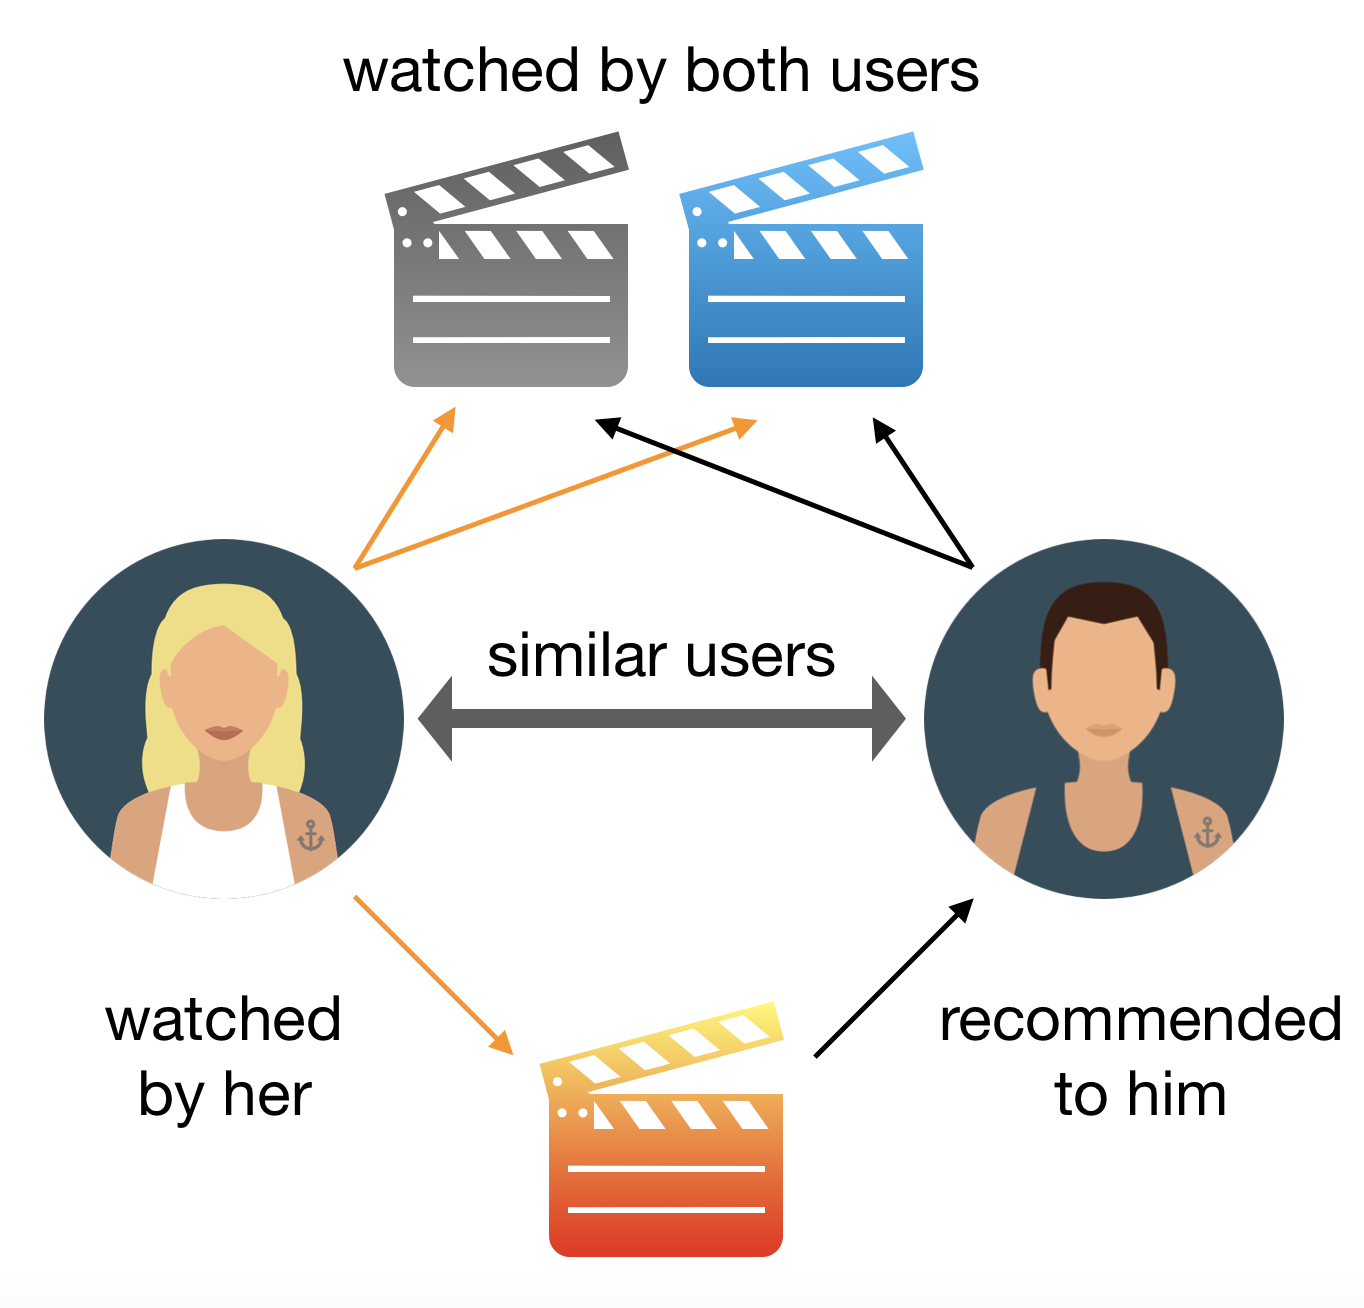

In [ ]:
from surprise.prediction_algorithms.knns import KNNBasic

In [ ]:
sim_options = {
    'name': 'cosine',
    'user_based': True
}

sim_user = KNNBasic(sim_options=sim_options,
                    verbose=False,
                    random_state=33)
sim_user.fit(trainset)

In [ ]:
sim_user.predict(uid=2, iid=17, r_ui=5.0)

Prediction(uid=2, iid=17, r_ui=5.0, est=4.166335018545322, details={'actual_k': 40, 'was_impossible': False})

In [ ]:
get_recommendations(ratings,
                    movies_md,
                    671,10,sim_user)

[('The Wizard', 5),
 ('Rio Bravo', 5),
 ('Festen', 5),
 ('Spider-Man 3', 5),
 ('A Streetcar Named Desire', 5),
 ('Gentlemen Prefer Blondes', 5),
 ('The Evil Dead', 5),
 ('JFK', 5),
 ("Singin' in the Rain", 5),
 ("Frank Herbert's Dune", 5)]



###Item-Based

In item based recommendation method we will be computing similarities between items(movies) and will fetch the most similar items(movies) using an algorithm(KNN) and will recommend items(movies) which one user likes to another user who likes similar kind of item(movie) and vice versa.

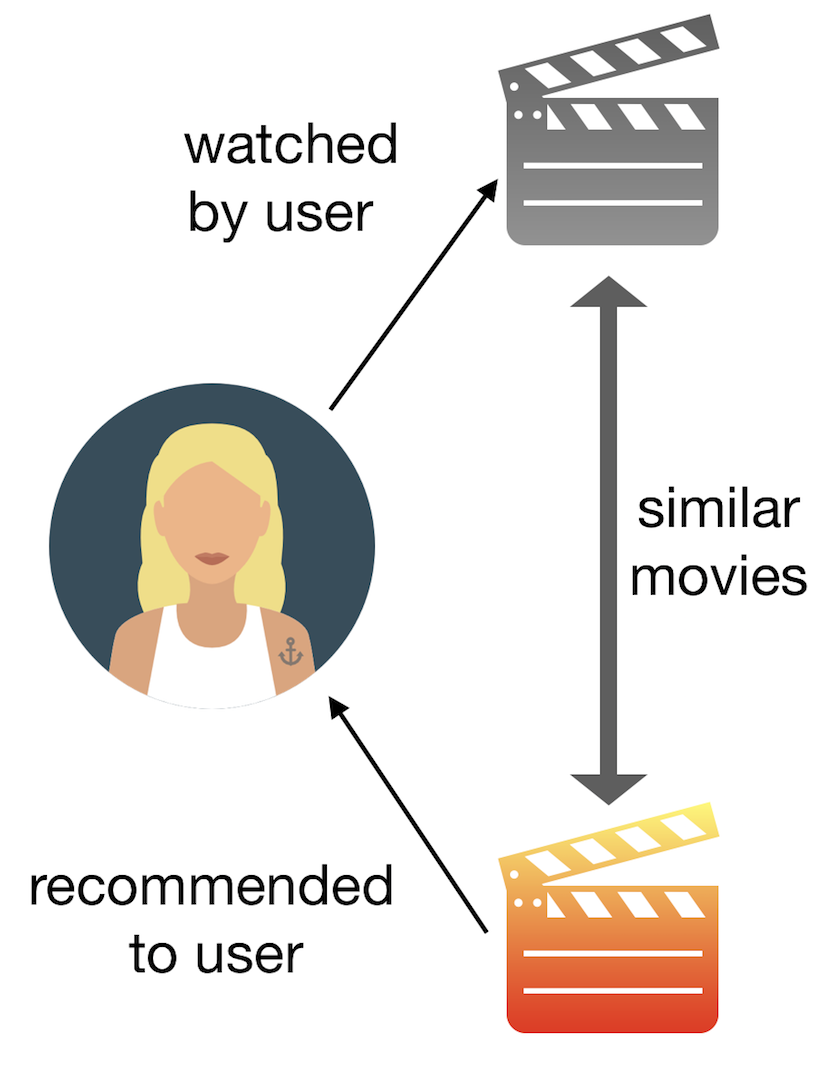

In [ ]:
sim_options = {
    'name': 'cosine',
    'user_based': False
}
sim_item = KNNBasic(sim_options=sim_options,
                    verbose=False,
                    random_state=33)

sim_item.fit(trainset)

In [ ]:
sim_item.predict(uid=3, iid=17, r_ui=5.0)

Prediction(uid=3, iid=17, r_ui=5.0, est=3.570435721981063, details={'actual_k': 20, 'was_impossible': False})

In [ ]:
get_recommendations(ratings, movies_md, 671,10,sim_item)

[('Hard Candy', 5),
 ('ビジターQ', 5),
 ('ต้มยำกุ้ง', 4.666666666666667),
 ('Shaun of the Dead', 4.571428571428571),
 ('The Silence of the Lambs', 4.503228000162119),
 ("Singin' in the Rain", 4.5),
 ("Hearts of Darkness: A Filmmaker's Apocalypse", 4.5),
 ('Sense and Sensibility', 4.5),
 ("The Hitchhiker's Guide to the Galaxy", 4.5),
 ('Sedmikrásky', 4.4375)]